## Installing all the necessary Packages

In [1]:
!pip install --upgrade pip

In [2]:
# First upgrade the environment.
from subprocess import run
# Add & Upgrade whatever you will need
modules =[
    'yfinance',    # Required for Yahoo Finance model
    'fredapi',     # Required to access FRED Data for MacroEconomics indices
    'ta'           # Required for the MACD indicator
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

In [3]:
# Text Formating {Fore Colors and Background Colors definition}
RESET = '\033[0m'
BOLD  = '\033[1m'
ITALIC= "\033[3m"
ULINE = '\033[4m'
BLINK = "\033[5m"
NEGATIVE = "\033[7m"

RED   = '\033[31m'
GREEN = '\033[32m'
YELLOW= '\033[33m'
BLUE  = '\033[34m'
PURPLE= '\033[35m'
CYAN  = '\033[36m'
WHITE = '\033[97m'

BgGREEN = '\033[42m'
BgYELLOW= '\033[43m'
BgBLUE  = '\033[44m'
BgWHITE = '\033[47m'

## Import All the General and commonly used Packages

In [4]:
# Import all the common modules
import os
import warnings
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred
from ta.trend import MACD
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Defining the reqired funtions

In [5]:
def Calculate_RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
def Calculate_EMA(data, n):
    ema_values = [data[0]]  # Initialize EMA list with the first value
    smoothing_factor = 2 / (n + 1)
    
    for i in range(1, len(data)):
        ema = (data[i] * smoothing_factor) + (ema_values[i - 1] * (1 - smoothing_factor))
        ema_values.append(ema)
    
    return ema_values

In [7]:
# Calculate On Balance Volume (OBV)
def Get_Obv(df):
    df['Daily Change'] = df['Price'].diff()
    df['Volume Direction'] = np.where(df['Daily Change'] >= 0, 1, -1)
    df['OBV'] = df['Volume Direction'] * df['Volume']
    df.fillna(0, inplace=True)
    df['OBV'] = df['OBV'].cumsum()
    df.drop(['Daily Change', 'Volume Direction'], axis=1, inplace=True)

In [8]:
def Validation_Dates(MaxDate, PredDays):
    # pd.Timestamp.today().normalize()-timedelta(days=1, hours=-0)

    if (MaxDate < pd.Timestamp.today().normalize()):
        Val_Dates = pd.date_range(end=MaxDate+timedelta(days=1, hours=-0), periods=PredDays, freq='B')
    else:
        Val_Dates = pd.date_range(end=MaxDate, periods=PredDays, freq='B')
    return Val_Dates


In [9]:
def FillGaps(StartingDate, EndingDate, StartVal, EndVal):
    import math

    # Generate business days for the year
    Business_Days = pd.date_range(start=StartingDate+timedelta(days=1, hours=0), end=EndingDate-timedelta(days=1, hours=0), freq='B')

    # Calculate the incremental value
    SVal = value = float(StartVal)
    EVal = value = float(EndVal)
    if (math.isnan(SVal)):
        Incremental_Value = 0
    elif ((not math.isnan(SVal)) & (math.isnan(EVal))):
        Incremental_Value = StartVal
    elif ((not math.isnan(SVal)) & (not math.isnan(EVal))):
        Incremental_Value = (EndVal - StartVal) / (len(Business_Days) + 1)

    return Incremental_Value

In [10]:
# Function to fetch MacroEconomics data from FRED
def Fetch_Series(APIKey, IndName, Series_ID):
    StartDate = pd.to_datetime('2003.01.01')
    EndDate = pd.Timestamp.today().normalize()
    Data_Dict = {}
    try:
        Data = APIKey.get_series(Series_ID, StartDate, EndDate)
        Data_Dict[IndName] = Data
        Df = pd.DataFrame(Data_Dict)
        Df.reset_index(inplace=True)
        Df.rename(columns={'index': 'Date'}, inplace=True)
        Df.sort_values(by=['Date'], ascending=[True], inplace=True)
        MaxDate = Df.Date.max()
        DfTmp = Df.copy()
        for row in range(0, len(Df)-1):
            StartDate = DfTmp.iloc[row, 0]
            StartVal = DfTmp.iloc[row, 1]
            EndDate = DfTmp.iloc[row+1, 0]
            EndVal = DfTmp.iloc[row+1, 1]
    
            IncVal = FillGaps(StartDate, EndDate, StartVal, EndVal)
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=1, hours=0), freq='B')
            Val = StartVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
    
        if (MaxDate < pd.Timestamp.today().normalize()):
            StartDate = MaxDate
            EndDate = pd.Timestamp.today().normalize()
            Business_Days = pd.date_range(start=StartDate+timedelta(days=1, hours=0), end=EndDate-timedelta(days=0, hours=0), freq='B')
            Val = EndVal
            for BDay in Business_Days:
                Val = Val + IncVal
                Df.loc[len(Df.index)] = [BDay, Val]
    except Exception as e:
        print(f"Error fetching {IndName}: {e}")
    return Df

In [11]:
def TestTheModel(Model):
    # Checking how good this Model will be
    # Forecast day(s) ahead based on Test Data
    y_Train_Pred = Model.predict(X_train)
    y_Test_Pred = Model.predict(X_test)
    
    # Calculate R² error
    r2_Train = r2_score(y_train, y_Train_Pred)
    r2_Test = r2_score(y_test, y_Test_Pred)
    
    # Display results
    print(f"R² error on Training Data: {r2_Train:.5f}")
    print(f"R² error on Test Data: {r2_Test:.5f}")
    
    # Confirm that R² error on Training Data is better than R² error on Test Data
    if (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.1) & ((r2_Train - r2_Test) < 0.2):
        if (r2_Train > r2_Test) & ((1.00 - r2_Train) < 0.001) & ((r2_Train - r2_Test) < 0.01):
            print(f'{BOLD+GREEN+BgWHITE}Very Good Model!{RESET}\n{BOLD+ITALIC+NEGATIVE+BgGREEN}R² error on Training Data is better than R² error on Test Data.{RESET}')
        else:
            print(f'{BOLD+BLUE+BgWHITE}Good Model!{RESET}\n{BOLD+ITALIC+NEGATIVE+BgBLUE}R² error on Training Data is better than R² error on Test Data.{RESET}')
    else:
        print(f'{BOLD+RED+BLINK+BgYELLOW}Bad Model.{RESET}')

In [12]:
def Plot_TrainTest(CrncyPair, Y_Train, Y_Test):
    # Plot Train and Test prices
    plt.figure(figsize=(10, 6))
    plt.plot(Y_Train.index, Y_Train.values, label='Training Data', color='blue')
    plt.plot(Y_Test.index, Y_Test.values, label='Test Data', color='orange')
    plt.title('The Train/Test data for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

In [13]:
def Rpt_Evaluate_Plot(CrncyPair, Model_Name, Model_Code, Y_Train, Y_Test, Y_Pred, MaxDate, Future_Preds):
    # Evaluate the model
    mae = mean_absolute_error(Y_Test, Y_Pred)
    print("Mean Absolute Error: {:.5f}".format(mae))
    # ============================================
    mse = mean_squared_error(Y_Test, Y_Pred)
    print("Mean Squared Error: {:.5f}".format(mse))
    # ===================================================
    rmse = np.sqrt(mse)
    print('Root Mean Squared Error: {:.5f}'.format(rmse))
    # ============================================
    r2 = r2_score(Y_Test, Y_Pred)
    print("R-squared (R2) score: {:.5f}".format(r2))
    # ============================================
    print('Future Predictions', Future_Preds)

    # Plotting the graph
    Future_Dates = pd.date_range(start=MaxDate+timedelta(days=1), periods=len(Future_Preds), freq="B")

    # Plot Actual vs Predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(Future_Dates, ActualValues, label='Actual Data', color='green')
    plt.plot(Future_Dates, Future_Preds, label='Predicted Data', color='blue')
    plt.scatter(Future_Dates, ActualValues, s=10, color='red')
    plt.scatter(Future_Dates, Future_Preds, s=10, color='red')
    plt.title(Model_Name + ': Actual vs Predicted values for ' + CrncyPair + ' Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

    # Inserting Record into the DataFrame
    Models_Compare.loc[len(Models_Compare.index)] = [Model_Name, Model_Code, mae, mse, rmse, r2]

## Load the Currency Pair into DataFrame

In [14]:
TDSData = []
YFinanceData = []

# Suppress all warnings
warnings.filterwarnings("ignore")

# Today's Date
TDate = pd.Timestamp.today().normalize()

In [15]:
# Every Currency Pair is a combination of Major and Minor currency
CrncyPair = 'USDCAD'
Major = CrncyPair[0:3]
Minor = CrncyPair[3:]

In [16]:
%%time
# DATA SOURCE 01 (TDS stored in GitHub)
# =====================================
# Data Source
Base_URL = 'https://raw.githubusercontent.com/Akubue4U/PyProjects/main/MyBDAThesis/TDS-Data/'

# Reading data frame from csv file
Symbol = Major + Minor +'_'

# Check if the URL exists and is accessible
SuccessCode = [200, 400]
response = requests.head(Base_URL, timeout=5)
if response.status_code in SuccessCode:
    
    # List to store DataFrames
    Df_List = []
    
    # Reading over 7,903,117 M1 data from GitHub
    # Iterate through the years and read each .csv file into a DataFrame
    for Year in range(2003, 2025):
        File_URL = f'{Base_URL}{Symbol}{Year}.csv'
        Df = pd.read_csv(File_URL)
            
        Df_List.append(Df)
    
    # Concatenate all DataFrames into one
    CombinedDf = pd.concat(Df_List, ignore_index=True)
    # Merge Date string and Time string, and convert to DateTime type
    CombinedDf['DateTime'] = pd.to_datetime((CombinedDf['Date'] + " " + CombinedDf['Time']), format='%Y.%m.%d %H:%M:%S')
    CombinedDf.drop(columns={'Date', 'Time'}, inplace=True)    
    CombinedDf.set_index(CombinedDf['DateTime'], inplace=True)

    # Stage 02
    # Subsample data to one-day time steps, including weekends
    DataOpen = CombinedDf.Open.resample('1D').first()
    DataHigh = CombinedDf.High.resample('1D').max()
    DataLow = CombinedDf.Low.resample('1D').min()
    DataClose = CombinedDf.Close.resample('1D').last()
    DataVolume = round(CombinedDf.TickVol.resample('1D').sum(), 2)
    
    # Merge the Data on a common key, Date
    TDSData = pd.merge(DataOpen, DataHigh, how='left', on=['DateTime'])
    TDSData = pd.merge(TDSData, DataLow, how='left', on=['DateTime'])
    TDSData = pd.merge(TDSData, DataClose, how='left', on=['DateTime'])
    TDSData = pd.merge(TDSData, DataVolume, how='left', on=['DateTime'])
    
    # Rename the index column to Date
    TDSData.reset_index(inplace=True)
    TDSData.rename(columns={'DateTime': 'Date', 'Close': 'Price', 'TickVol': 'Volume'}, inplace=True)
    TDSData.set_index('Date', inplace=True)
    TDSData.dropna(inplace = True)

    #TDSData.drop(columns=['TickVol'], inplace=True)

    # Also sort the Data by Dates to allign with Source 02 below.
    TDSData.sort_values(by=['Date'], ascending=[True], inplace=True)
    DataSource = TDSData.copy()
    print("Data Source in use is TDS.")
else:
    # DATA SOURCE 02 (Yahoo Finance)
    # ==============================
    # Download historical data for the Currency Pair using Yahoo Finance
    YHCrncyPair = CrncyPair + '=X'
    YFinanceData = yf.download(YHCrncyPair, start="2000-01-01", end=TDate-timedelta(days=1, hours=-0))

    YFinanceData.rename(columns={"Close": "Price"}, inplace=True)
    YFinanceData.drop(YFinanceData.columns[[4, 5]], axis=1, inplace=True)

    # Drop rows with missing values
    YFinanceData.dropna(inplace=True)
    YFinanceData.sort_values(by=['Date'], ascending=[True], inplace=True)
    DataSource = YFinanceData.copy()
    print("Data Source in use is Finance.")

Data Source in use is TDS.
CPU times: user 5.81 s, sys: 1.55 s, total: 7.36 s
Wall time: 39.1 s


In [17]:
# Free the momory by deleting the DataFrames no longer needed
del TDSData
del YFinanceData

In [18]:
DataSource.tail(7).sort_values(by=['Date'], ascending=[False])

,Open,High,Low,Price,Volume
Date,,,,,
2024-10-25,1.38528,1.38971,1.38376,1.38904,63093
2024-10-24,1.38341,1.38682,1.38120,1.38537,67221
2024-10-23,1.38153,1.38622,1.38116,1.38355,71485
2024-10-22,1.38297,1.38373,1.38132,1.38174,59304
2024-10-21,1.37981,1.38492,1.37978,1.38303,60605
2024-10-18,1.37912,1.38145,1.37777,1.37921,67490
2024-10-17,1.37509,1.38007,1.37467,1.37944,68187


In [19]:
print(len(DataSource))

5562


#### Adding the Statistical Data to the DataSource

In [20]:
# Feature Engineering: Calculate rolling averages, momentum indicators, etc.
DataSource['SMA_20'] = DataSource['Price'].rolling(window=20).mean()
DataSource['SMA_50'] = DataSource['Price'].rolling(window=50).mean()
DataSource['RSI'] = Calculate_RSI(DataSource['Price'], window=14)
DataSource['EMA_12'] = Calculate_EMA(DataSource['Price'], 12)
DataSource['EMA_26'] = Calculate_EMA(DataSource['Price'], 26)
DataSource['MACD'] = MACD(DataSource['Price']).macd()

# Drop rows with missing values
DataSource.dropna(inplace=True)

#### Get the MacroEconomics Data

In [21]:
# My FRED API key
MyAPIKey = Fred(api_key='fb871b8abb01c472840cdd407ffd8dca')

# This is the list of Indices we want to retrieve for USA and Canada
MacroEconomic_Series_USA = {
    'CPI': 'CPIAUCSL',  # Consumer Price Index (USA)
    'IntRate': 'FEDFUNDS',  # Federal Funds Rate (USA)
    'UnEmployRate': 'UNRATE',  # Unemployment Rate (USA)
    'Imports': 'IMP0004',  # Imports (USA)
    'Exports': 'EXP0004'  # Exports (USA)
}

MacroEconomic_Series_Canada = {
    'CPI': 'CANCPIALLMINMEI',  # Consumer Price Index (Canada)
    'IntRate': 'IR3TIB01CAM156N',  # Interest Rate (Canada)
    'UnEmployRate': 'LRUNTTTTCAM156S',  # Unemployment Rate (Canada)
    'Imports': 'XTIMVA01CAM667S',  # Imports (Canada)
    'Exports': 'XTEXVA01CAM667S'  # Exports (Canada)
}

In [22]:
%%time
# Get the MacroEconomics Data
# Fetch data for USA
USA_Data = []
for IndName, Series_ID in MacroEconomic_Series_USA.items():
    Data = Fetch_Series(MyAPIKey, IndName, Series_ID)
    if (len(USA_Data) ==  0):
        USA_Data = Data.copy()
    else:
        USA_Data = pd.merge(USA_Data, Data, on='Date')
USA_Data.rename(columns={"CPI": "USA_CPIs", "IntRate": "USA_IntRates", "UnEmployRate": "USA_UnEmployRates", "Imports": "USA_Imports", "Exports": "USA_Exports"}, inplace=True)
#USA_Data = USA_Data.drop_duplicates()


# Fetch data for Canada
Canada_Data = []
for IndName, Series_ID in MacroEconomic_Series_Canada.items():
    Data = Fetch_Series(MyAPIKey, IndName, Series_ID)
    if (len(Canada_Data) ==  0):
        Canada_Data = Data.copy()
    else:
        Canada_Data = pd.merge(Canada_Data, Data, on='Date')
Canada_Data.rename(columns={"CPI": "CAN_CPIs", "IntRate": "CAN_IntRates", "UnEmployRate": "CAN_UnEmployRates", "Imports": "CAN_Imports", "Exports": "CAN_Exports"}, inplace=True)
#Canada_Data = Canada_Data.drop_duplicates()

# Merge the MacroEconomic datasets on a common key, such as Date
MacroEcons = pd.merge(USA_Data, Canada_Data, on='Date')

# Free the memory.
#del USA_Data, Canada_Data

CPU times: user 27.6 s, sys: 29.6 ms, total: 27.6 s
Wall time: 30.5 s


#### Mering the MacroEconomics Data with the DataSource

In [23]:
%%time
# Merge the DataSource with the MacroEconomic dataset on a common key, such as Date
Complete_Data = pd.merge(DataSource, MacroEcons, how='left', on=['Date'])

# Set NaN to Zero, and column 'Date' as the index
Complete_Data.fillna(0, inplace=True)
Complete_Data.set_index('Date', inplace=True)

# Free the memory.
#del DataSource, MacroEcons

CPU times: user 5.2 ms, sys: 16 µs, total: 5.21 ms
Wall time: 4.45 ms


## The Models

In [24]:
# Write the Performance Metrics to a DataFrame for easy comparism.
# Define column names
Cols = ['ModelName', 'ModelCode', 'MAE', 'MSE', 'RMSE', 'R2']

# Create DataFrame
Models_Compare = pd.DataFrame(columns = Cols)

In [25]:
# Model Common/Global parameters & Modules
# Here, I choose to use 85% of my data for Training and the remaing 15% for Testing.
TestPercent = 0.15
TrainPercent = 1.0 - TestPercent

# Predictions
PredDays = 5

#### Creating Label column for the Forecast

In [26]:
# Creating 'Label' column for the forecast
#pd.options.mode.chained_assignment = None 
Complete_Data['Label'] = Complete_Data['Price'].shift(-(PredDays))
Complete_Data.dropna(inplace=True)
MaxDate = Complete_Data.index.max()
ActualValues = Complete_Data['Label'][-(PredDays):].values

#### Split the Data, Scale, and Plot Train/Test

In [27]:
#Split data into train/test (85/15 ratio) with caution for time series
Complete_Data.dropna(inplace=True)
Split_Position = int(len(Complete_Data) * TrainPercent)
Train_Data, Test_Data = Complete_Data.iloc[:Split_Position], Complete_Data.iloc[Split_Position:]

In [28]:
# Scale data
Scaler = StandardScaler()
Train_Data_Scaled = Scaler.fit_transform(Train_Data.drop('Label', axis=1))
Test_Data_Scaled = Scaler.transform(Test_Data.drop('Label', axis=1))

In [29]:
# Convert the scaled data back into a DataFrame for easy inspection
Train_Data_Scaled_Df = pd.DataFrame(Train_Data_Scaled, columns=Train_Data.drop('Label', axis=1).columns)
Test_Data_Scaled_Df = pd.DataFrame(Test_Data_Scaled, columns=Test_Data.drop('Label', axis=1).columns)

# Handle missing values
Train_Data_Scaled_Df.dropna(inplace=True)
Test_Data_Scaled_Df.dropna(inplace=True)

In [30]:
# Match into Training and Testing data
X_train, y_train = Train_Data_Scaled_Df, Train_Data['Label']
X_test, y_test = Test_Data_Scaled_Df, Test_Data['Label']

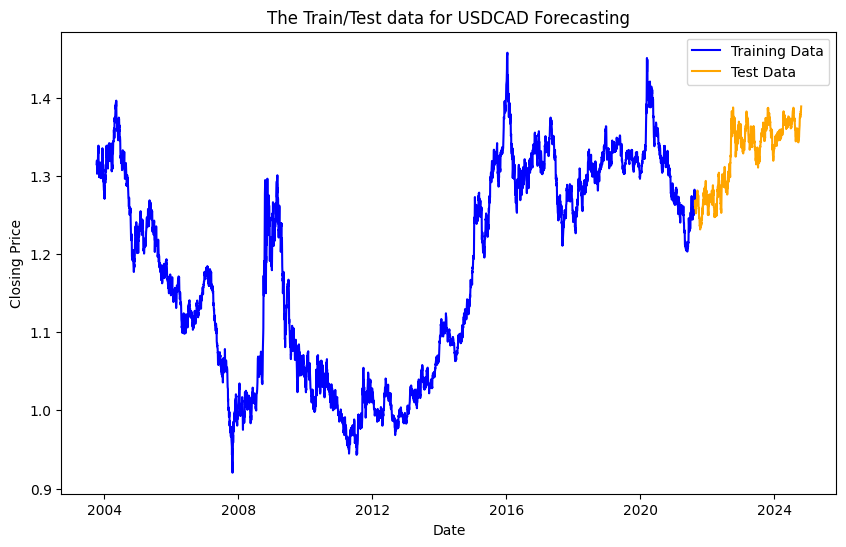

In [31]:
# Plotting the Train/Test Data
Plot_TrainTest(CrncyPair, y_train, y_test)

#### Linear Regression Model

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
# Instantiate Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Checking how good this Model will be
TestTheModel(model)

R² error on Training Data: 0.98860
R² error on Test Data: 0.81403
Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01523
Mean Squared Error: 0.00033
Root Mean Squared Error: 0.01824
R-squared (R2) score: 0.81403
Future Predictions [1.3617756  1.35978113 1.358072   1.36195532 1.36184752]


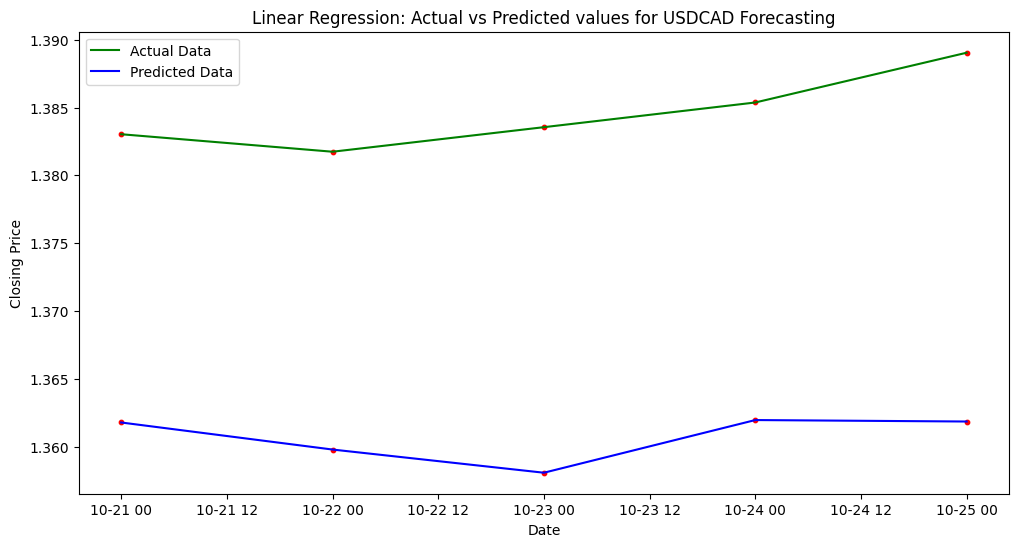

CPU times: user 402 ms, sys: 813 ms, total: 1.21 s
Wall time: 162 ms


In [35]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LNR'
ModelName = 'Linear Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Random Forest Regressor Model

In [36]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier

In [37]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=None)
model.fit(X_train, y_train)

RandomForestRegressor()

In [38]:
# Checking how good this Model will be
TestTheModel(model)

R² error on Training Data: 0.99939
R² error on Test Data: 0.85409
Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01318
Mean Squared Error: 0.00026
Root Mean Squared Error: 0.01615
R-squared (R2) score: 0.85409
Future Predictions [1.3789328 1.375719  1.350137  1.3779601 1.3783937]


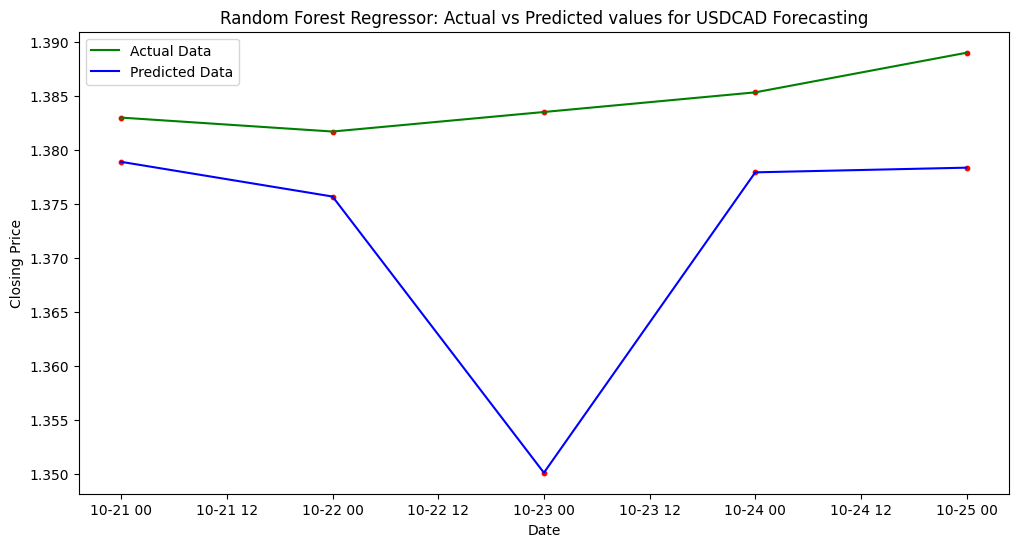

CPU times: user 158 ms, sys: 218 ms, total: 376 ms
Wall time: 141 ms


In [39]:
%%time
# Evaluate the model
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RFR'
ModelName = 'Random Forest Regressor'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### XGBoost Model

In [40]:
import xgboost as xgb

In [41]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',   # Use squared error loss for regression
    'max_depth': 6,                    # Maximum depth of trees
    'learning_rate': 0.1,              # Learning rate {0.1}
    'n_estimators': 100,               # Number of boosting rounds (trees)
    'seed': 42                         # Random seed for reproducibility {42}
}

# Instantiate XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
# Checking how good this Model will be
TestTheModel(xgb_model)

R² error on Training Data: 0.99779
R² error on Test Data: 0.57337
Bad Model.


Mean Absolute Error: 0.02342
Mean Squared Error: 0.00076
Root Mean Squared Error: 0.02762
R-squared (R2) score: 0.57337
Future Predictions [1.3480871 1.348184  1.3354276 1.3481042 1.3481042]


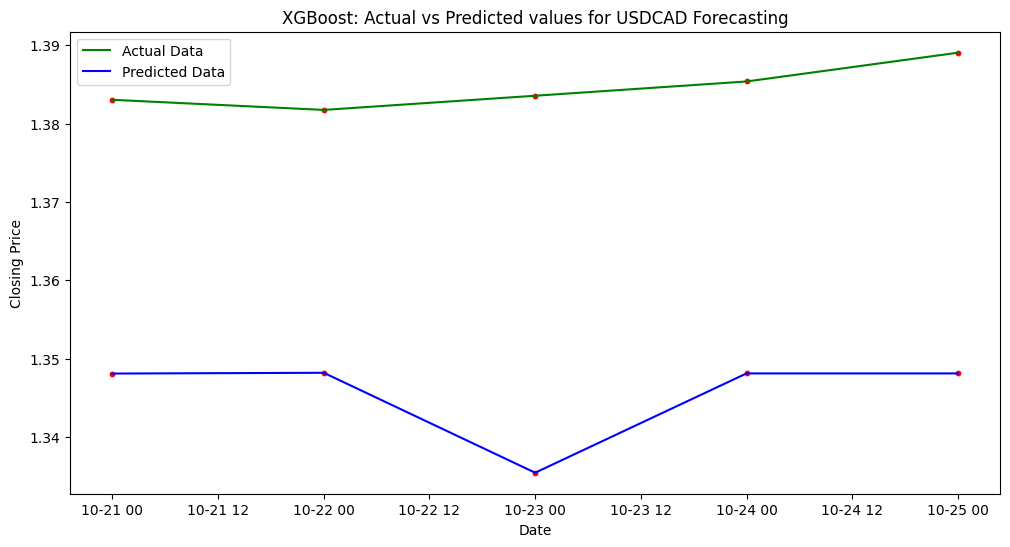

CPU times: user 227 ms, sys: 205 ms, total: 432 ms
Wall time: 125 ms


In [43]:
%%time
# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'XGB'
ModelName = 'XGBoost'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del xgb_model, y_pred, future_predictions

#### Ridge Regression Model

In [44]:
from sklearn.linear_model import Ridge

In [45]:
# Instantiate and fit the Ridge Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [46]:
# Checking how good this Model will be
TestTheModel(model)

R² error on Training Data: 0.98860
R² error on Test Data: 0.81411
Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01524
Mean Squared Error: 0.00033
Root Mean Squared Error: 0.01823
R-squared (R2) score: 0.81411
Future Predictions [1.36176761 1.35983355 1.35795813 1.36165868 1.36156106]


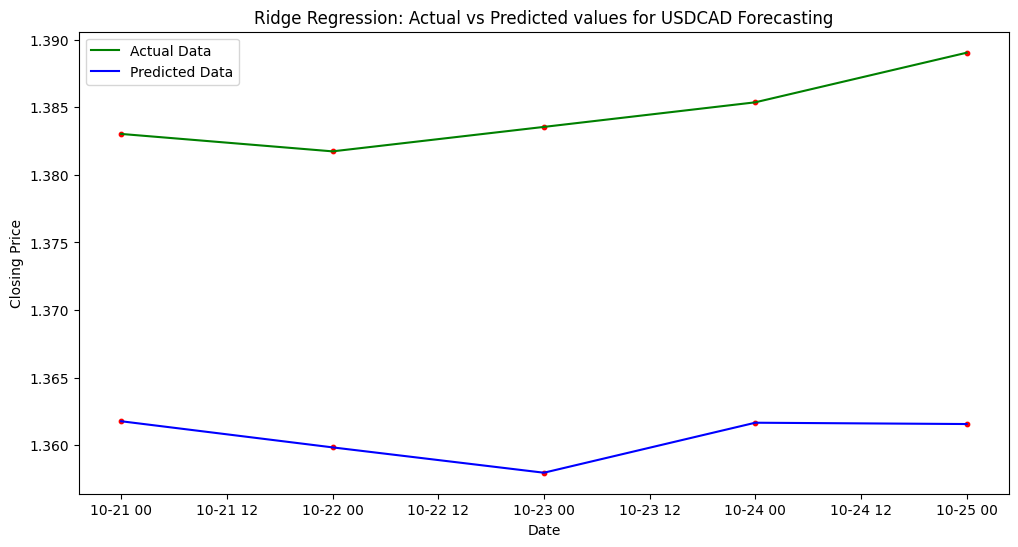

CPU times: user 236 ms, sys: 965 ms, total: 1.2 s
Wall time: 169 ms


In [47]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'RIR'
ModelName = 'Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Lasso Regression Model

In [48]:
from sklearn.linear_model import Lasso

In [49]:
# Instantiate and fit the Lasso Regression model
alpha = 0.1  # Regularization strength (hyperparameter to be tuned)
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

Lasso(alpha=0.1)

In [50]:
# Checking how good this Model will be
TestTheModel(model)

R² error on Training Data: 0.41248
R² error on Test Data: -6.90475
Bad Model.


Mean Absolute Error: 0.11429
Mean Squared Error: 0.01414
Root Mean Squared Error: 0.11890
R-squared (R2) score: -6.90475
Future Predictions [1.22562859 1.22514845 1.2245977  1.22562859 1.22557446]


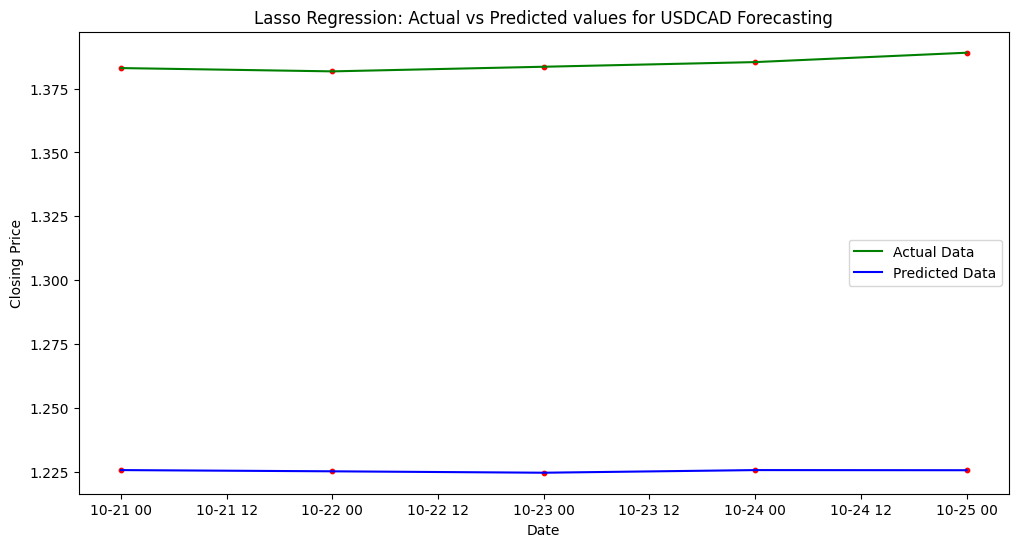

CPU times: user 249 ms, sys: 947 ms, total: 1.2 s
Wall time: 160 ms


In [51]:
%%time
# Make predictions on the testing set
y_pred = model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'LAR'
ModelName = 'Lasso Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del model, y_pred, future_predictions

#### Support Vector Regression (SVR) Model

In [52]:
from sklearn.svm import SVR

In [53]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train, y_train)

SVR(epsilon=0.2)

In [54]:
# Checking how good this Model will be
TestTheModel(svr_model)

R² error on Training Data: 0.36564
R² error on Test Data: -9.01604
Bad Model.


Mean Absolute Error: 0.12668
Mean Squared Error: 0.01791
Root Mean Squared Error: 0.13384
R-squared (R2) score: -9.01604
Future Predictions [1.20111262 1.20132557 1.20131545 1.20149712 1.20153699]


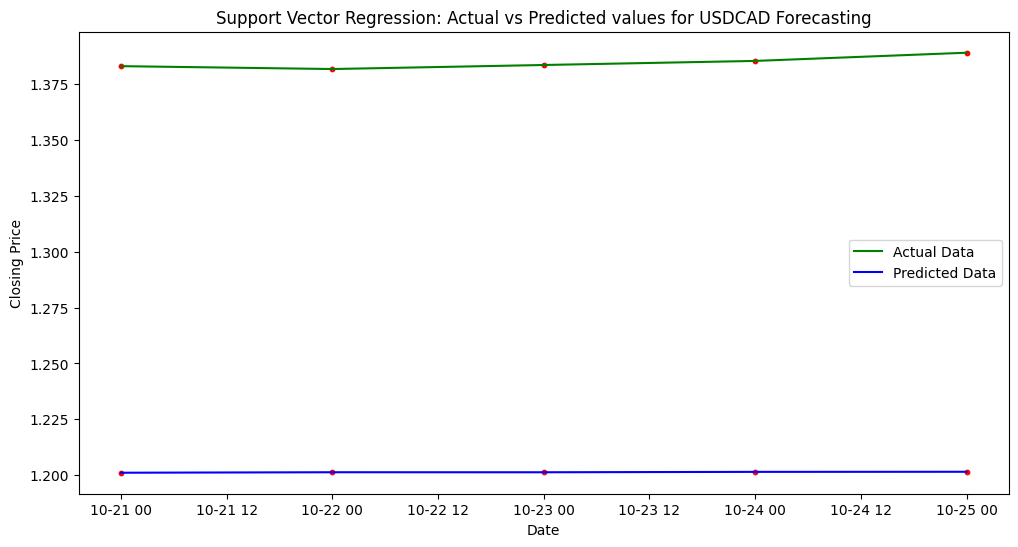

CPU times: user 142 ms, sys: 202 ms, total: 344 ms
Wall time: 125 ms


In [55]:
%%time
# Make predictions on the testing set
y_pred = svr_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'SVR'
ModelName = 'Support Vector Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del svr_model, y_pred, future_predictions

#### Bayesian Ridge Regression Model

In [56]:
from sklearn.linear_model import BayesianRidge

In [57]:
Baye_model = BayesianRidge()
Baye_model.fit(X_train, y_train)

BayesianRidge()

In [58]:
# Checking how good this Model will be
TestTheModel(Baye_model)

R² error on Training Data: 0.98859
R² error on Test Data: 0.81464
Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01522
Mean Squared Error: 0.00033
Root Mean Squared Error: 0.01821
R-squared (R2) score: 0.81464
Future Predictions [1.36179528 1.35990566 1.3579594  1.3615737  1.36148796]


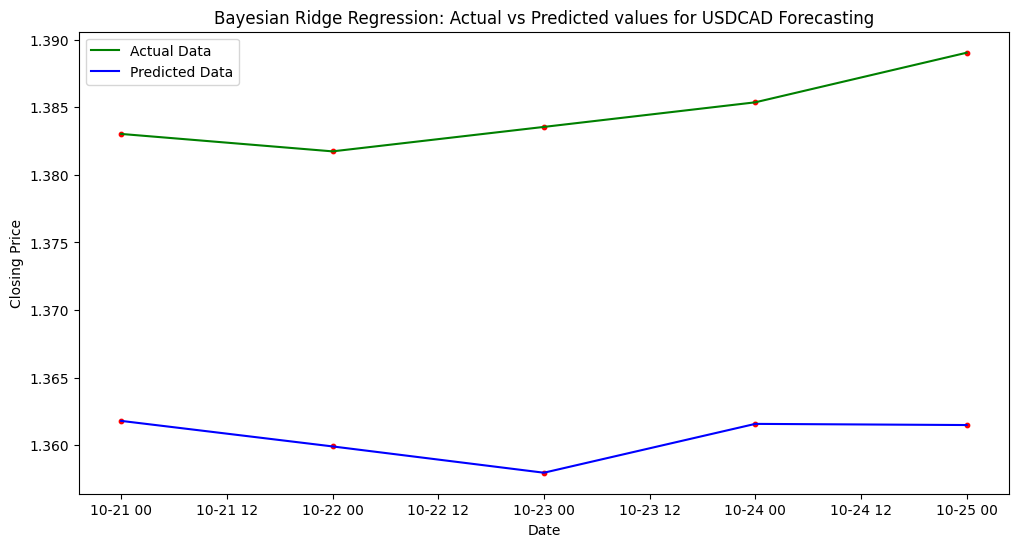

CPU times: user 516 ms, sys: 705 ms, total: 1.22 s
Wall time: 266 ms


In [59]:
%%time
# Make predictions on the testing set
y_pred = Baye_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'BRR'
ModelName = 'Bayesian Ridge Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del Baye_model, y_pred, future_predictions

#### AdaBoost Regression Model

In [60]:
from sklearn.ensemble import AdaBoostRegressor

In [61]:
AdaB_model = AdaBoostRegressor(n_estimators=100, random_state=None)
AdaB_model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100)

In [62]:
# Checking how good this Model will be
TestTheModel(AdaB_model)

R² error on Training Data: 0.98591
R² error on Test Data: 0.87611
Good Model!
R² error on Training Data is better than R² error on Test Data.


Mean Absolute Error: 0.01141
Mean Squared Error: 0.00022
Root Mean Squared Error: 0.01489
R-squared (R2) score: 0.87611
Future Predictions [1.38784663 1.38784663 1.3680804  1.38784663 1.38784663]


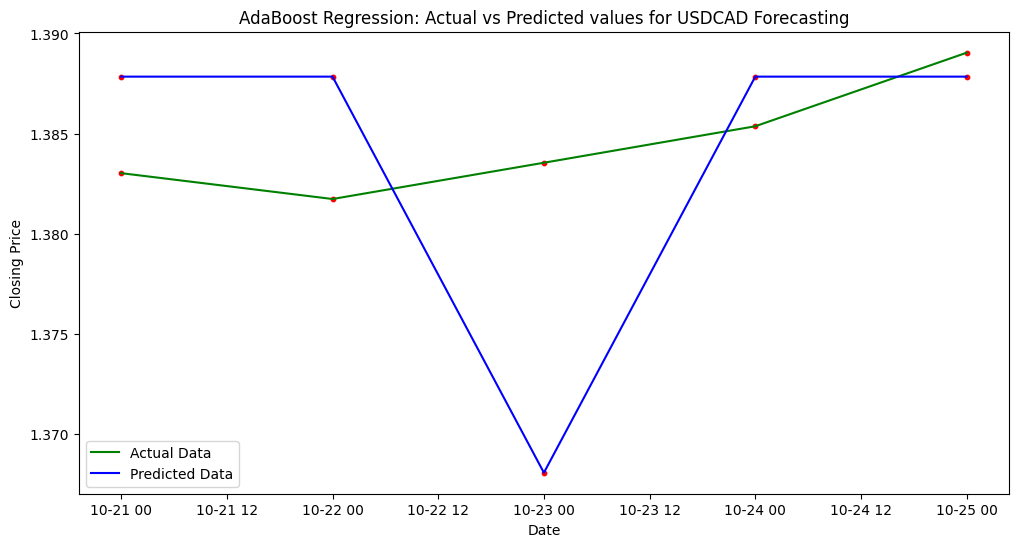

CPU times: user 144 ms, sys: 202 ms, total: 346 ms
Wall time: 130 ms


In [63]:
%%time
# Make predictions on the testing set
y_pred = AdaB_model.predict(X_test)
future_predictions = y_pred[-(PredDays):]

# Evaluate and Report Accuracy, Predict the future, and Plot the graph.
ModelCode = 'ABR'
ModelName = 'AdaBoost Regression'
Rpt_Evaluate_Plot(CrncyPair, ModelName, ModelCode, y_train, y_test, y_pred, MaxDate, future_predictions)

# Delete the following objects so as to free the memory, and also Re-Set the objects for the next Model.
del AdaB_model, y_pred, future_predictions

## Summary of the model results

In [64]:
Models_Compare

,ModelName,ModelCode,MAE,MSE,RMSE,R2
0,Linear Regression,LNR,0.015229,0.000333,0.018237,0.814029
1,Random Forest Regressor,RFR,0.013179,0.000261,0.016154,0.854094
2,XGBoost,XGB,0.023421,0.000763,0.027623,0.573369
3,Ridge Regression,RIR,0.015241,0.000332,0.018233,0.814112
4,Lasso Regression,LAR,0.114287,0.014137,0.118901,-6.904750
5,Support Vector Regression,SVR,0.126684,0.017913,0.133841,-9.016037
6,Bayesian Ridge Regression,BRR,0.015224,0.000332,0.018207,0.814639
7,AdaBoost Regression,ABR,0.011409,0.000222,0.014885,0.876108


In [65]:
Models_Compare[['ModelName','MAE','MSE','RMSE','R2']]

,ModelName,MAE,MSE,RMSE,R2
0,Linear Regression,0.015229,0.000333,0.018237,0.814029
1,Random Forest Regressor,0.013179,0.000261,0.016154,0.854094
2,XGBoost,0.023421,0.000763,0.027623,0.573369
3,Ridge Regression,0.015241,0.000332,0.018233,0.814112
4,Lasso Regression,0.114287,0.014137,0.118901,-6.904750
5,Support Vector Regression,0.126684,0.017913,0.133841,-9.016037
6,Bayesian Ridge Regression,0.015224,0.000332,0.018207,0.814639
7,AdaBoost Regression,0.011409,0.000222,0.014885,0.876108


In [66]:
# Free the Memory
#del FxPair_Data, X, y, X_train, X_test, y_train, y_test